# MBTI Project

## By The Introverts 
1. Nan Lin
2. Zack Pan
3. Ben Khuong
4. Tomohiko Ishihara
5. Donya Fozoonmayeh

#  For saving time, find and run step1,2,3 before modeling:

In [1]:
reset -fs

In [1]:
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string 
import re
from collections import Counter
import numpy as np
plt.style.use('fivethirtyeight')

In [2]:
mbti = pd.read_csv('data/mbti_1.csv') 

## General info:
#### Personality Types:

First, we take a look at distribution of the MBTI personality types

<BarContainer object of 16 artists>

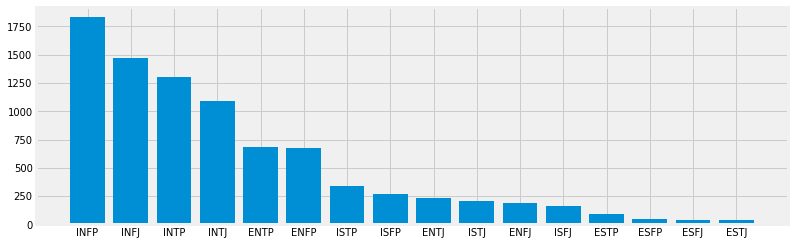

In [3]:
stat = mbti['type'].value_counts()
plt.figure(figsize=(12,4))
plt.bar(stat.index,stat.values)

4 capitals' meaning:
- extroversion vs. introversion 
- intuition vs. sensing
- thinking vs. feeling
- judging vs. perceiving

In [4]:
# Types per category
# analyze types by sub-category may be easier
mbti['EorI']= mbti['type'].apply(lambda x:x[0])
mbti['NorS']= mbti['type'].apply(lambda x:x[1])
mbti['TorF']= mbti['type'].apply(lambda x:x[2])
mbti['JorP']= mbti['type'].apply(lambda x:x[3])

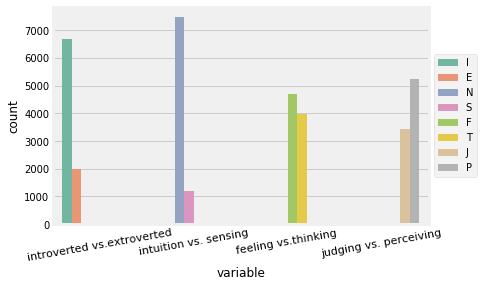

In [5]:
ax = sns.countplot(x='variable',hue='value',data=pd.melt(mbti.iloc[:,2:]),palette="Set2")
ax.set_xticklabels(["introverted vs.extroverted", "intuition vs. sensing", 
                    "feeling vs.thinking ", "judging vs. perceiving", 
                    ], rotation=10, fontsize=11)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Imbalanced class: I vs E, N vs S. Some advanced techniques like resampling methods may be needed later to handle imbalanced classes.

#### Their last 50 posts:
Focus on some statistics(mean,variance) of posts

words they averagely used in per comment

In [6]:
mbti['avg_comment_length'] = mbti['posts'].apply(lambda x: len(x.split())/50)
mbti['comment_length_var'] = mbti['posts'].apply(lambda x: np.var([len(sentence.split()) for sentence in x.split('|||')]))

In [7]:
mbti.head()

,type,posts,EorI,NorS,TorF,JorP,avg_comment_length,comment_length_var
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J,11.12,135.2900
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,23.40,187.4756
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,16.72,180.6900
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J,21.28,181.8324
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J,19.34,196.4576


/Users/donya/miniconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


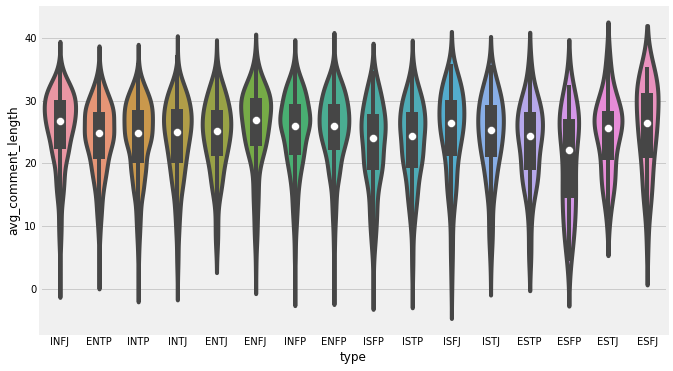

In [8]:
plt.figure(figsize=(10,6))
sns.violinplot(x='type', y='avg_comment_length', data=mbti)

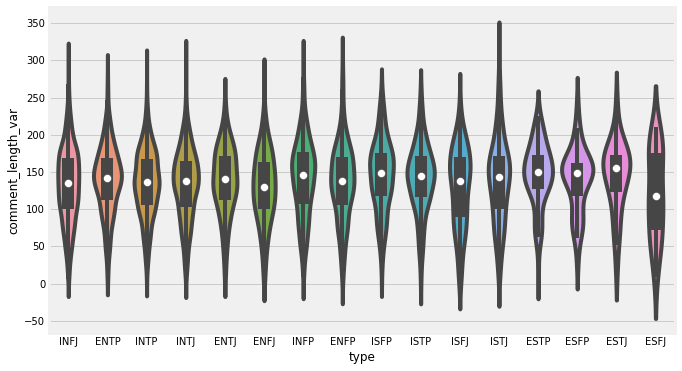

In [9]:
plt.figure(figsize=(10,6))
sns.violinplot(x='type', y='comment_length_var', data=mbti)

## Data preprocessing

### Define a function for cleaning the posts:
- Remove "|||" and links and punctuations and MBTI words(As u see in the text, real names user referring to are changed to MBTI type)
- Lowercase
- Lemmatize word, remove stop words and words less than 3 characters (lemmatizing would be better than stemming but takes more time)

In [10]:
# get 16 types of personality list for removing MBTI words in the following function
types = list(mbti.iloc[:,0].unique())
types = [t.lower() for t in types]

In [12]:
def post_preprocess(df):
    i = 0
    post_list = []
    length = len(df)
    lemmatiser = WordNetLemmatizer() # or use PorterStemmer(), if want to run faster
    print('Processing... Be patient')
    
    for row in df.iterrows():
        # Progress bar
        i+=1
        if (i % 500 == 0 or i == length):
            print(f"Progress bar：{round(i/length*100)}%")
        # clean the posts
        posts = row[1].posts
        posts = re.sub(r'\|\|\|',' ',posts)
        posts = re.sub(r'http[\S]*', '', posts).lower()
        posts = re.sub("[^a-z\s]", ' ', posts)
        posts = ' '.join([lemmatiser.lemmatize(w) for w in posts.split(' ') if w not in stopwords.words('english')])
        for t in types:
            posts = posts.replace(t,'')
        post_list.append(posts)
        
    return np.array(post_list)      

In [13]:
# Here I takes 15mins to run it T_T
#processed_post = post_preprocess(mbti)

# Step1

In [15]:
# save time, run this to load the clean post
processed_post = pd.read_csv('data/mbti_preprocessed_1.csv')
processed_post.drop('Unnamed: 0',axis=1,inplace=True)
processed_post.head()

,type,posts,processed_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter top ten play pr...
1,ENTP,'I'm finding the lack of me in these posts ver...,finding lack post alarming sex boring positi...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course say know blessing...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear enjoyed conversation day esoteric ...
4,ENTJ,'You're fired.|||That's another silly misconce...,fired another silly misconception approachi...


### Word Cloud

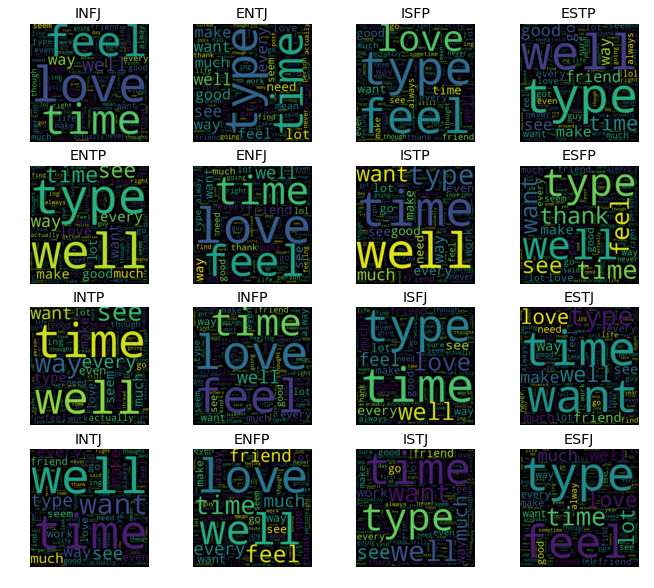

In [16]:
# u can skip this cell. Don't run it!
dim = int(len(processed_post['type'].unique())**0.5)
fig, ax = plt.subplots(nrows=dim, ncols=dim, figsize=(10, 10))
j = 0
for i, mbti_type in enumerate(processed_post['type'].unique()):
    if i % dim == 0 and i != 0:
        j += 1
    # filter the very common words 
    posts = [re.sub(r'(people)|(know)|(think)|(one)|(really)|(thing)|(say)','', user_posts) 
             for user_posts in processed_post[processed_post['type'] == mbti_type]['processed_posts']]
    cloud = WordCloud(height=400).generate(" ".join(posts))
    ax[i%dim,j].imshow(cloud, interpolation='bilinear')
    ax[i%dim,j].axis("off")
    ax[i%dim,j].set_title(mbti_type)

Might need to remove words like think, people, know, thing later to make it intuitive. To be continue...

### Define a function to transfer the types? (Maybe useful for modeling)

In [17]:
# A type consists of 4 capitals and each capital corresponds to 2 possible characteristics.
# For later encoding and modeling issues, let's tranfer them into separate binary code.
type_map = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
# transfer column 3-6 into binary code.
def type_preprocess(df):
    for i in range(2,6):
        df.iloc[:,i] = df.iloc[:,i].map(type_map)
    return df

In [18]:
mbti = type_preprocess(mbti)

In [19]:
mbti.head()

,type,posts,EorI,NorS,TorF,JorP,avg_comment_length,comment_length_var
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,0,11.12,135.2900
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,1,23.40,187.4756
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,1,16.72,180.6900
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,0,21.28,181.8324
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,0,19.34,196.4576


# Step2

### Posts Vectorized

Create a bag of words representation of each user by using tfidf

In [20]:
# Chose TfidfVectorizer with min_df = 25 because there were some odd cases like 'aaaaa' 
# max_df=.8 to filter common words. Max_features to set limit for the length of each vector
# here I take 5000 just compared to Ben's 7857, 5000 means 5000 words with higher frequency among words. 
# I don't dare to filter out some word less than 3 characters 
# since there are some acronym or words like 'aha' which may contain positive info.
vectorizer = TfidfVectorizer(max_df=.8, min_df=25)
word_count = vectorizer.fit_transform(processed_post['processed_posts'])
# Create word_count dataframe
word_tfidf_df = pd.DataFrame(data = word_count.toarray(), columns = vectorizer.get_feature_names())
word_tfidf_df.head()

,aa,ab,aback,abandon,abandoned,abandoning,abandonment,abbey,abbreviation,abhor,...,zelda,zen,zero,zodiac,zombie,zone,zoned,zoning,zoo,zoom
0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.06229,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Sentiment Score 

**Caution:** Takes a few minutes to run

In [21]:
# Sentiment Score of clean post
analyzer = SentimentIntensityAnalyzer()
scores = []
length_p = len(processed_post)
for i in range(length_p):
    score = analyzer.polarity_scores(processed_post['processed_posts'][i])['compound']
    scores.append(score)
    # Print Progress 
    if (i % 500 == 0 or i == length_p-1):
            print(f"Progress bar：{round(i/length_p*100)}%")

Progress bar：0%
Progress bar：6%
Progress bar：12%
Progress bar：17%
Progress bar：23%
Progress bar：29%
Progress bar：35%
Progress bar：40%
Progress bar：46%
Progress bar：52%
Progress bar：58%
Progress bar：63%
Progress bar：69%
Progress bar：75%
Progress bar：81%
Progress bar：86%
Progress bar：92%
Progress bar：98%
Progress bar：100%


In [22]:
# Sentiment Score of original post
analyzer = SentimentIntensityAnalyzer()
scores_d = []
length_p = len(processed_post)
for i in range(length_p):
    score_d = analyzer.polarity_scores(processed_post['posts'][i])['compound']
    scores_d.append(score_d)
    # Print Progress 
    if (i % 500 == 0 or i == length_p-1):
            print(f"Progress bar：{round(i/length_p*100)}%")

Progress bar：0%
Progress bar：6%
Progress bar：12%
Progress bar：17%
Progress bar：23%
Progress bar：29%
Progress bar：35%
Progress bar：40%
Progress bar：46%
Progress bar：52%
Progress bar：58%
Progress bar：63%
Progress bar：69%
Progress bar：75%
Progress bar：81%
Progress bar：86%
Progress bar：92%
Progress bar：98%
Progress bar：100%


Text(0.5, 1.0, 'Sentiment Score Distribution')

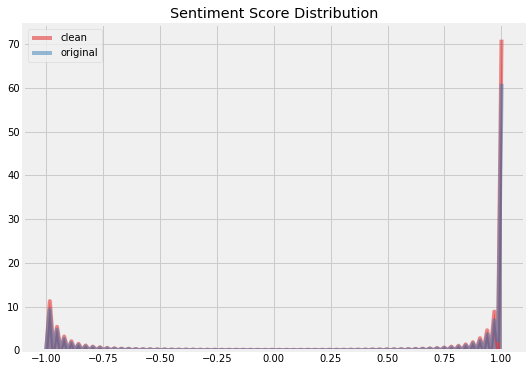

In [23]:
# check the difference
f, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 6))
c1, c2 = sns.color_palette('Set1', 2)
sns.kdeplot(scores, shade=True, color=c1, label='clean', alpha=0.5, ax=ax)
sns.kdeplot(scores_d, shade=True, color=c2, label='original', alpha=0.5, ax=ax)
ax.set_title('Sentiment Score Distribution')

There is not so much difference on scores between original posts and processed ones. We choose the processed ones as a feature

In [24]:
mbti['Sentiment'] = scores

### Ellipses count

Counting number of ellipsies used per user.

In [25]:
# Create a list of ellpsies count per user. This is an indicator for long posts 
ellipses_count = [len(re.findall(r'\.\.\.\|\|\|',posts)) for posts in mbti['posts']]
# Append to dataset 
mbti['ellipses'] = ellipses_count

### Exclamation count
Counting number of exclamation marks used per user. 

In [26]:
# Create a list of exclamation count per user. 
exclamation_count = [len(re.findall(r'!',posts)) for posts in mbti['posts']]
# Append to dataframe
mbti['exclamation'] = exclamation_count

### Question count
Counting number of question marks used per user. 

In [27]:
# Create a list of question count per user. 
question_count = [len(re.findall(r'\?',posts)) for posts in mbti['posts']]
# Append to dataframe
mbti['question'] = question_count

### Link count
Counting number of links used per user. 

In [28]:
# For each user, remove ||| to make it easier to find links. 
user_posts = [re.sub(r'\|\|\|',' ',posts) for posts in mbti['posts']]
# Create a list of link count per user. 
link_count = [len(re.findall(r'http[\S]* ', posts)) for posts in user_posts]
# Append to dataframe
mbti['links'] = link_count

### Picture count

In [29]:
# Create a list of question count per user. 
question_count = [len(re.findall(r'(\.png)|(\.jpg)',posts)) for posts in mbti['posts']]
# Append to dataframe
mbti['picture'] = question_count

### Emojies count
We should probably modify the text_style_emojies to include more.

In [30]:
def find_emoji(text):
    # REMOVE LATER ON
    text = text.lower()
    
    text = re.sub(r'\|\|\|', ' ', text)
    
    slack_style_emojies = re.findall(r':[\w\d]+(\-[\w\d]+)?:', text)
    text_style_emojies = re.findall(r':[\-|\s]?[d|\)|\(|p]', text)
    
    return slack_style_emojies + text_style_emojies

In [31]:
mbti['emojies'] = mbti['posts'].map(lambda x: len(find_emoji(x)))

### Upper case count

In [32]:
def del_punct(text):
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    return regex.sub("", text)

temp = mbti['posts'].apply(lambda x: del_punct(x))
mbti['upper'] = temp.apply(lambda x: len([x for x in x.split() if x.isupper()]))

In [33]:
mbti.head()

,type,posts,EorI,NorS,TorF,JorP,avg_comment_length,comment_length_var,Sentiment,ellipses,exclamation,question,links,picture,emojies,upper
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,0,11.12,135.2900,0.9924,8,3,18,24,6,4,13
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,1,23.40,187.4756,0.9987,18,0,5,9,8,14,82
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,1,16.72,180.6900,0.9985,13,4,12,4,0,10,26
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,0,21.28,181.8324,0.9985,23,3,11,2,0,0,57
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,0,19.34,196.4576,0.9914,20,1,10,6,2,1,35


### Save it

In [34]:
mbti.to_csv("data/mbti_FE.csv",index=False)

# Step3

## Base Model: MultinomialNB

In [35]:
mbti = pd.read_csv("data/mbti_FE.csv")

In [36]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [49]:
def base_model(model, X, target, nsplits=4):
    kf = StratifiedShuffleSplit(n_splits=nsplits)

    for col in target.columns:
        print(f"This is the training for {col}:")
        y = target[col]
        for train, test in kf.split(X,y):
            X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
            probs = np.ones((len(y_test), 16))
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            fscore = f1_score(y_test, preds, average='weighted')
            accuracy = accuracy_score(preds, y_test)
            model_name = str(model).split('(')[0]
            print(f'{model_name} F1-score: {fscore}; Accuracy: {accuracy}')

In [38]:
# initialize
MNB = MultinomialNB()
Logistic = LogisticRegression(random_state=0, solver='sag', max_iter=10)
target = mbti.iloc[:,2:6]
X = np.column_stack((mbti.iloc[:,6:].drop('Sentiment',axis=1),word_tfidf_df))

In [39]:
base_model(MNB, X, target, nsplits=5)

This is the training for EorI:
MultinomialNB F1-score: 0.7052581977491458; Accuracy: 0.7073732718894009
MultinomialNB F1-score: 0.6827794562448316; Accuracy: 0.6808755760368663
MultinomialNB F1-score: 0.7141395968348679; Accuracy: 0.7188940092165899
MultinomialNB F1-score: 0.6989159231579423; Accuracy: 0.7027649769585254
MultinomialNB F1-score: 0.7035838933415401; Accuracy: 0.7073732718894009
This is the training for NorS:
MultinomialNB F1-score: 0.7927434296167911; Accuracy: 0.8271889400921659
MultinomialNB F1-score: 0.7795610479744276; Accuracy: 0.8168202764976958
MultinomialNB F1-score: 0.7932510392898791; Accuracy: 0.8387096774193549
MultinomialNB F1-score: 0.8001249085967621; Accuracy: 0.847926267281106
MultinomialNB F1-score: 0.808124166647173; Accuracy: 0.8433179723502304
This is the training for TorF:
MultinomialNB F1-score: 0.6302191819576926; Accuracy: 0.630184331797235
MultinomialNB F1-score: 0.6530485988039838; Accuracy: 0.6532258064516129
MultinomialNB F1-score: 0.61557516

In [40]:
base_model(Logistic, X, target, nsplits=5)

This is the training for EorI:
LogisticRegression F1-score: 0.677716304975214; Accuracy: 0.7695852534562212
LogisticRegression F1-score: 0.686100424188616; Accuracy: 0.7741935483870968
LogisticRegression F1-score: 0.6756969830420946; Accuracy: 0.7695852534562212
LogisticRegression F1-score: 0.6848158359389493; Accuracy: 0.771889400921659
LogisticRegression F1-score: 0.6822648421575742; Accuracy: 0.7707373271889401
This is the training for NorS:
LogisticRegression F1-score: 0.7977597298900396; Accuracy: 0.8617511520737328
LogisticRegression F1-score: 0.7977597298900396; Accuracy: 0.8617511520737328
LogisticRegression F1-score: 0.7977597298900396; Accuracy: 0.8617511520737328
LogisticRegression F1-score: 0.7977597298900396; Accuracy: 0.8617511520737328
LogisticRegression F1-score: 0.7977597298900396; Accuracy: 0.8617511520737328
This is the training for TorF:
LogisticRegression F1-score: 0.6238284873245927; Accuracy: 0.6255760368663594
LogisticRegression F1-score: 0.6100025048759828; Acc

In [43]:
# takes forever to train and not as accurate as the other models 
from sklearn import tree
decisionTree = tree.DecisionTreeClassifier()
base_model(decisionTree, X, target, nsplits=5)

This is the training for EorI:
DecisionTreeClassifier F1-score: 0.6627529033499959; Accuracy: 0.6693548387096774
DecisionTreeClassifier F1-score: 0.6913333881939872; Accuracy: 0.6935483870967742
DecisionTreeClassifier F1-score: 0.6615451349374186; Accuracy: 0.6624423963133641
DecisionTreeClassifier F1-score: 0.6776575682645174; Accuracy: 0.6762672811059908
DecisionTreeClassifier F1-score: 0.6630627970099234; Accuracy: 0.6670506912442397
This is the training for NorS:
DecisionTreeClassifier F1-score: 0.781429733773469; Accuracy: 0.7891705069124424
DecisionTreeClassifier F1-score: 0.780215715340102; Accuracy: 0.7764976958525346
DecisionTreeClassifier F1-score: 0.7779498979724743; Accuracy: 0.7741935483870968
DecisionTreeClassifier F1-score: 0.7661898945858859; Accuracy: 0.7557603686635944
DecisionTreeClassifier F1-score: 0.787408914861617; Accuracy: 0.7811059907834101
This is the training for TorF:
DecisionTreeClassifier F1-score: 0.5881006229895691; Accuracy: 0.5887096774193549
Decision

In [45]:
knn2 = KNeighborsClassifier(n_neighbors=30)
base_model(knn2, X, target)

This is the training for EorI:
KNeighborsClassifier F1-score: 0.6730448113385888; Accuracy: 0.7684331797235023
KNeighborsClassifier F1-score: 0.6688122007235172; Accuracy: 0.7684331797235023
KNeighborsClassifier F1-score: 0.6724539528725155; Accuracy: 0.7672811059907834
KNeighborsClassifier F1-score: 0.6742249461992423; Accuracy: 0.7707373271889401
This is the training for NorS:
KNeighborsClassifier F1-score: 0.7977597298900396; Accuracy: 0.8617511520737328
KNeighborsClassifier F1-score: 0.7977597298900396; Accuracy: 0.8617511520737328
KNeighborsClassifier F1-score: 0.7977597298900396; Accuracy: 0.8617511520737328
KNeighborsClassifier F1-score: 0.7977597298900396; Accuracy: 0.8617511520737328
This is the training for TorF:
KNeighborsClassifier F1-score: 0.6157913374104385; Accuracy: 0.6163594470046083
KNeighborsClassifier F1-score: 0.6266542495290156; Accuracy: 0.6267281105990783
KNeighborsClassifier F1-score: 0.6023668675133017; Accuracy: 0.6048387096774194
KNeighborsClassifier F1-sco

### Additional things to Consider:

* N grams (or is this more of a step tuning with count vectorizer? 

I think we can adjust this parameter when modeling
* About modeling: Which one is better? Training models for predicting EI,NS,TF,JP or just predicting type?